In [2]:
library(tidyverse)
options(repr.plot.height=6, repr.plot.width=10)
theme_set(theme_classic())

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()       masks stats::filter()
✖ purrr::flatten()      masks jsonlite::flatten()
✖ lubridate::interval() masks tsibble::interval()
✖ dplyr::lag()          masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# STATS 504 
## Week 5: Solar weather and GOES data

## Space weather
https://www.youtube.com/watch?v=oOXVZo7KikE

## About the data source
- The Geostationary Operational Environmental Satellites (GOES) are a series of satellites in geostationary orbit.
- They collect:
    - [Terrestrial weather data](https://www.star.nesdis.noaa.gov/goes/) (cloud cover, storms, hurricanes, etc.)
    - Atmospheric observations (temperature, humidity, solar radiation)
    - [Space weather data](https://www.swpc.noaa.gov/products/goes-x-ray-flux) (our focus)

# Understanding GOES X-ray Flux Measurements

- There are two GOES measurements:
  - Flux1 (Short Channel): Captures higher-energy X-rays with shorter wavelengths (0.5–4.0 Å). Sensitive to more intense solar events.
  - Flux2 (Long Channel): Captures lower-energy X-rays with longer wavelengths (1.0–8.0 Å). Used to classify solar flares.
- The Flux2 measurement is primarily used for classifying the magnitude of solar flares (e.g., C-class, M-class, X-class) based on the peak flux level.
- The ratio of Flux1 to Flux2 can provide insights into the temperature and emission characteristics of the solar plasma during flare events.

## The raw data
(Importing in R turned out to be difficult so I [switched over to Python](prep.ipynb))

In [27]:
df <- arrow::read_feather("goes2018.feather")  # not posted to github, too large


In [28]:
df %>% 
    mutate(t = lubridate::make_date(Year, Month, Day),
              t = t + dseconds(Time)             
             ) -> df

# (Too) big data
- We can already see that the data are very large and contain a lot of noise. This will make analysis complicated.
- We can effectively deal with both problems by averaging.


In [32]:
library(slider)

df_smoothed <- df %>% 
    filter(Month == 1, Day == 1) %>% 
    ggplot(aes(x = t, y = Flux2)) + geom_line()

In [38]:
library(slider)

df %>% 
    filter(Month == 1, Day == 1) %>% 
    mutate(Flux2_smooth = slide_dbl(Flux2, mean, .before = 10000, .after = 10000)) %>% 
    sample_frac(.01) %>% 
    ggplot(aes(x = t, y = Flux2_smooth)) + geom_line()

## Daily averages
To get a very "high" level picture of the data, we can do the usual thing and summarize by each day:

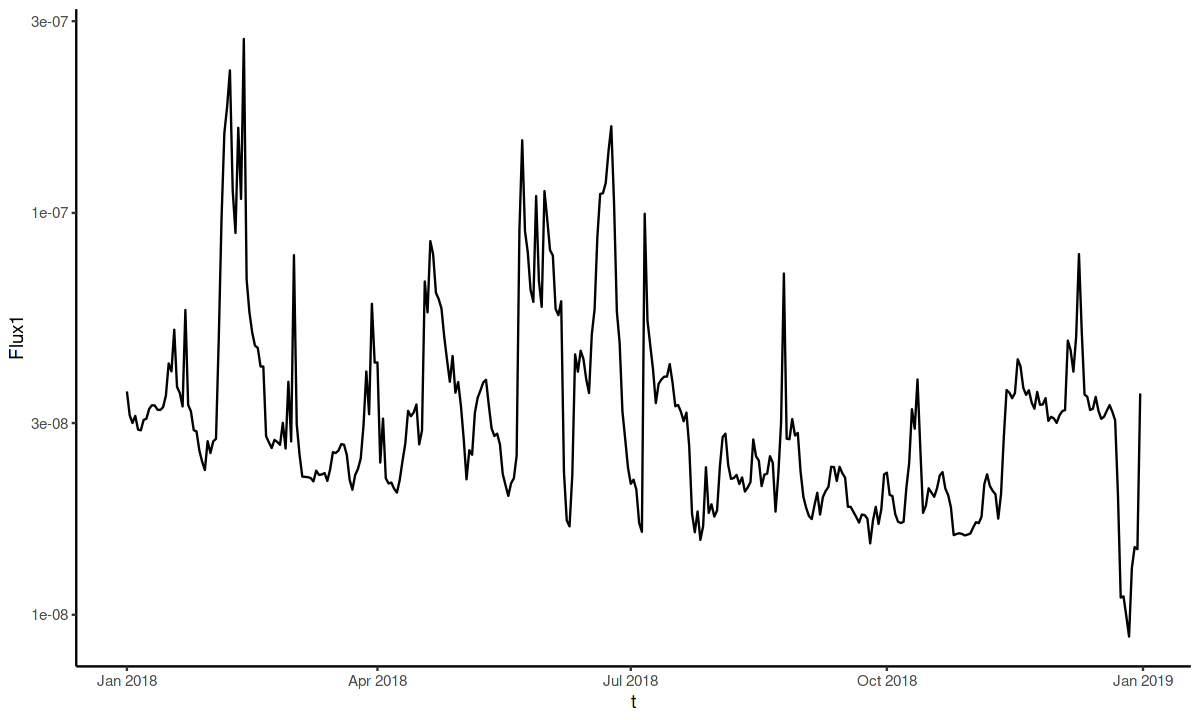

In [7]:
# a summarized view

For the rest of the lecture, we'll work with data summarized by daily average:

In [93]:
# goes_daily <- arrow::read_feather('goes_daily.feather') %>% mutate(date = make_datetime(year, month, day))
# save(goes_daily, file="goes_daily.RData")

In [96]:
load(url('https://github.com/terhorst/stats504/raw/refs/heads/main/lectures/week5/goes_daily_2.RData'))
goes_daily %>% print

              t  sat   flux1_mean   flux2_mean flux1_logmean flux2_logmean
0    1980-01-04 go02 1.726347e-06 2.379783e-08    -13.315640     -17.94168
1    1980-01-05 go02 1.691449e-06 2.569799e-08    -13.333417     -17.97886
2    1980-01-06 go02 3.479739e-06 2.761435e-07    -12.904953     -17.25269
3    1980-01-07 go02 3.347606e-06 1.735538e-07    -13.002044     -17.45621
4    1980-01-08 go02 4.204871e-06 3.946333e-07    -12.830895     -16.87275
5    1980-01-09 go02 2.762496e-06 1.647243e-07    -13.011159     -17.99093
6    1980-01-10 go02 5.609191e-06 5.243886e-07    -12.531193     -16.70821
7    1980-01-11 go02 3.473751e-06 1.036893e-07    -12.691345     -16.98271
8    1980-01-12 go02 4.852758e-06 2.243373e-07    -12.384569     -16.16959
9    1980-01-13 go02 5.314279e-06 3.563169e-07    -12.457948     -16.30301
10   1980-01-14 go02 4.128042e-06 2.834238e-07    -12.938496     -17.46382
11   1980-01-15 go02 1.985840e-06 3.349303e-08    -13.260713     -17.97018
12   1980-01-16 go02 1.58

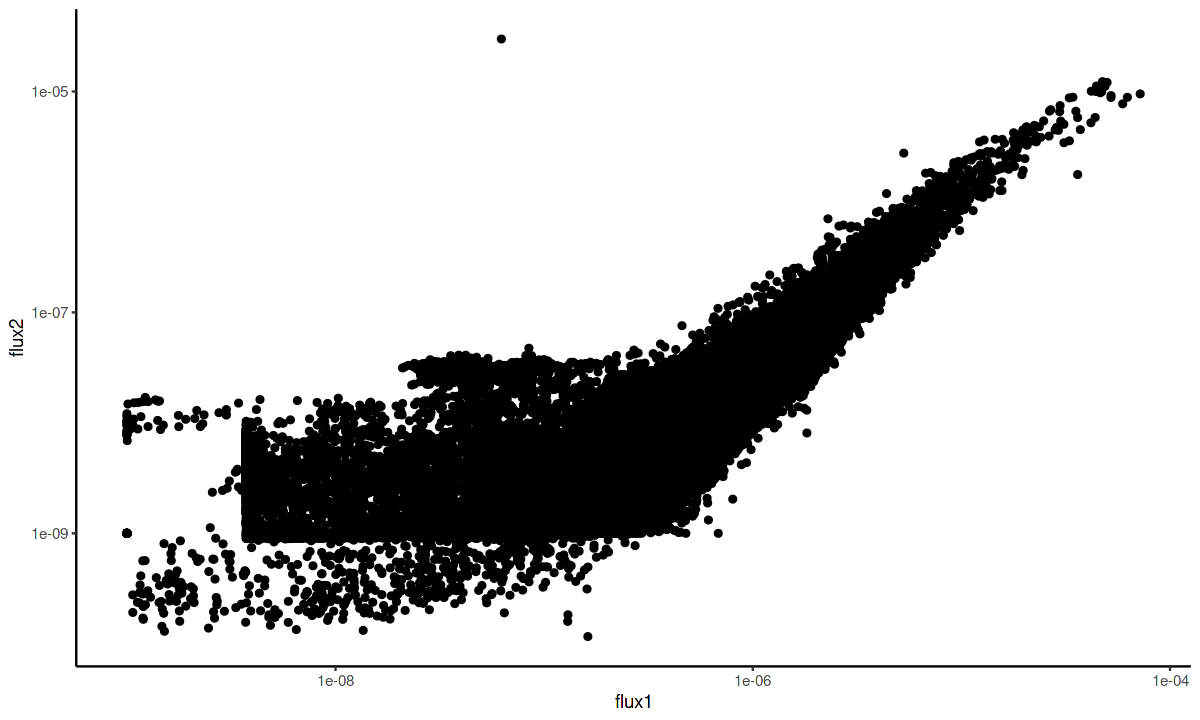

In [51]:
# The raw data
goes_daily %>% 
    filter(pmax(flux1, flux2) <= 1e-3) %>% 
    ggplot + geom_point(aes(x=flux1, y=flux2)) + scale_x_log10() + scale_y_log10()

# Some key questions
- Outliers?
- Missing data?
- What is the relationship between Flux1 and Flux2 (if any)?

In [97]:
goes_daily %>% pivot_longer(flux1:flux2) %>% print

# A tibble: 43,092 × 7
    year month   day sat   date                name         value
   <int> <int> <int> <fct> <dttm>              <chr>        <dbl>
 1  1980     1     4 go02  1980-01-04 00:00:00 flux1 0.00000173  
 2  1980     1     4 go02  1980-01-04 00:00:00 flux2 0.0000000238
 3  1980     1     5 go02  1980-01-05 00:00:00 flux1 0.00000169  
 4  1980     1     5 go02  1980-01-05 00:00:00 flux2 0.0000000257
 5  1980     1     6 go02  1980-01-06 00:00:00 flux1 0.00000348  
 6  1980     1     6 go02  1980-01-06 00:00:00 flux2 0.000000276 
 7  1980     1     7 go02  1980-01-07 00:00:00 flux1 0.00000335  
 8  1980     1     7 go02  1980-01-07 00:00:00 flux2 0.000000174 
 9  1980     1     8 go02  1980-01-08 00:00:00 flux1 0.00000420  
10  1980     1     8 go02  1980-01-08 00:00:00 flux2 0.000000395 
# ℹ 43,082 more rows


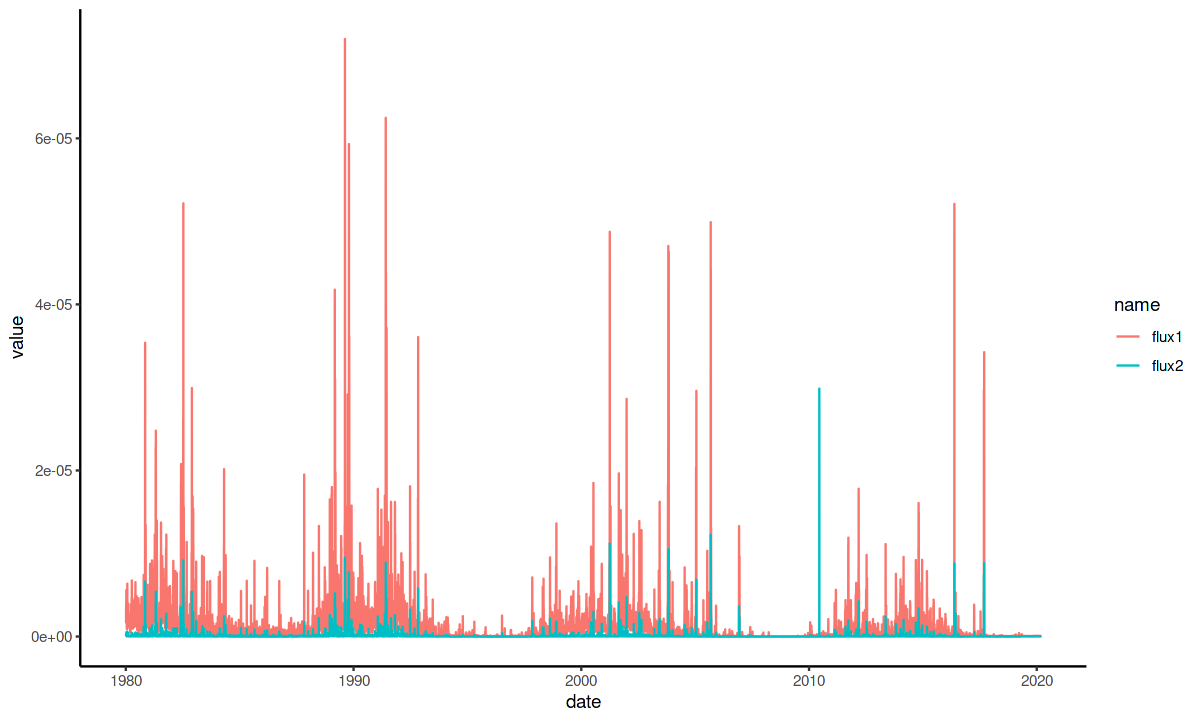

In [63]:
goes_daily %>% 
    filter(pmax(flux1, flux2) < 1e-3) %>% 
    pivot_longer(flux1:flux2) %>% 
    ggplot + 
    geom_line(aes(x = date, y = value, color = name))

## What is the distribution of Flux? 
- What is the marginal distribution of Flux1/Flux2?
- What is their joint distribution?
- Are these distributions constant over time?
- How do `time`, `Sat` and `name` enter into the picture?

## Marginal distributions

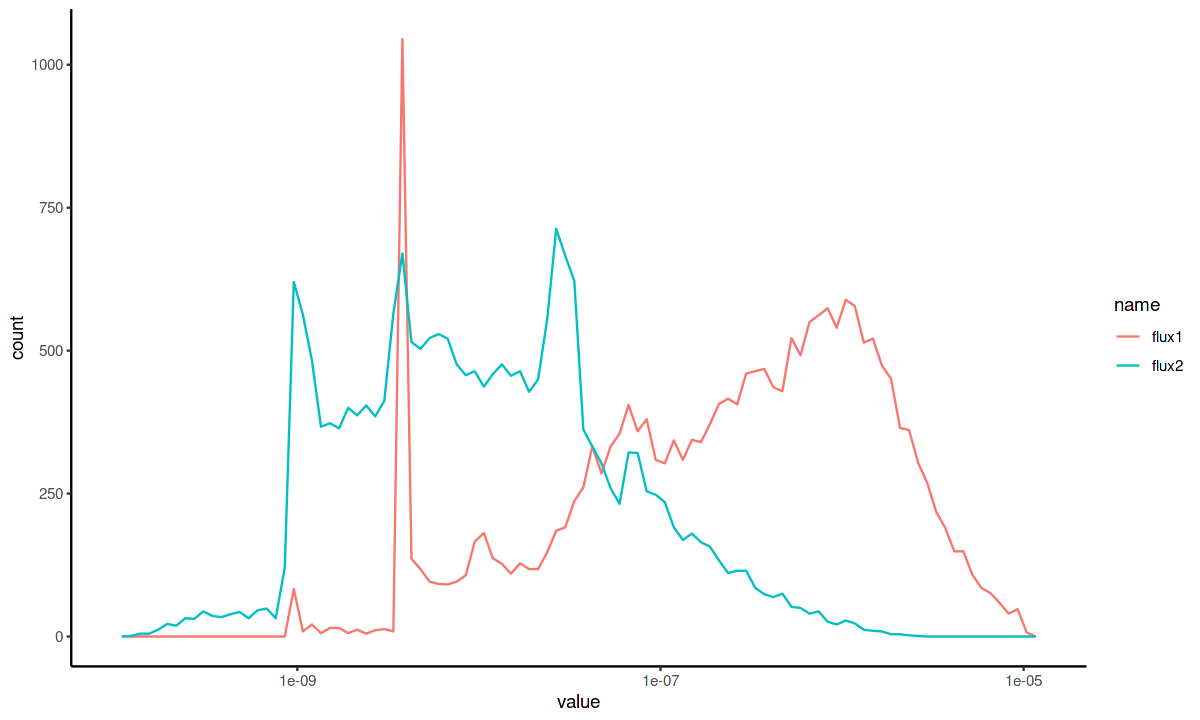

In [78]:
goes_daily %>% 
    filter(pmax(flux1, flux2) < 1e-5) %>%
    pivot_longer(flux1:flux2) %>% 
    ggplot() + geom_freqpoly(aes(x=value, color=name), bins = 100) +
    scale_x_log10()

## Joint distributions
How are `flux1` and `flux2` jointly distributed?

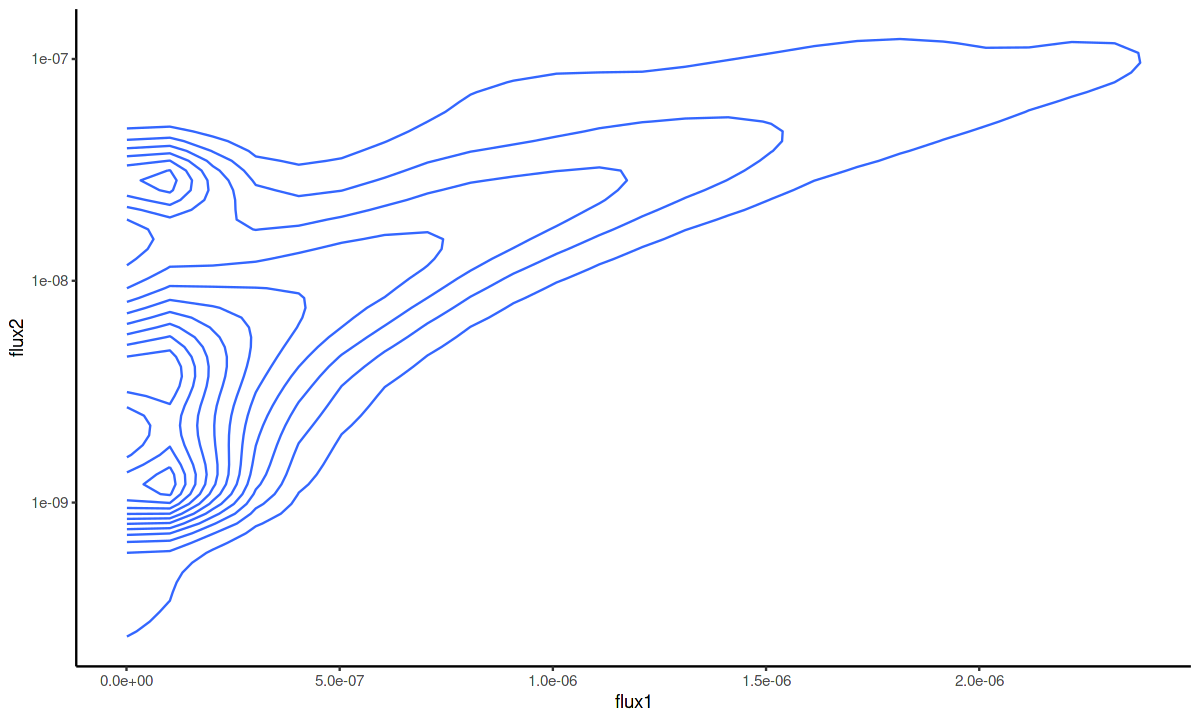

In [81]:
goes_daily %>%  
    filter(pmax(flux1, flux2) < 1e-5) %>% 
    ggplot + geom_density_2d(aes(x=flux1, y=flux2)) + 
    scale_y_log10()

## Variation over time
Is the distribution of the data constant across time?

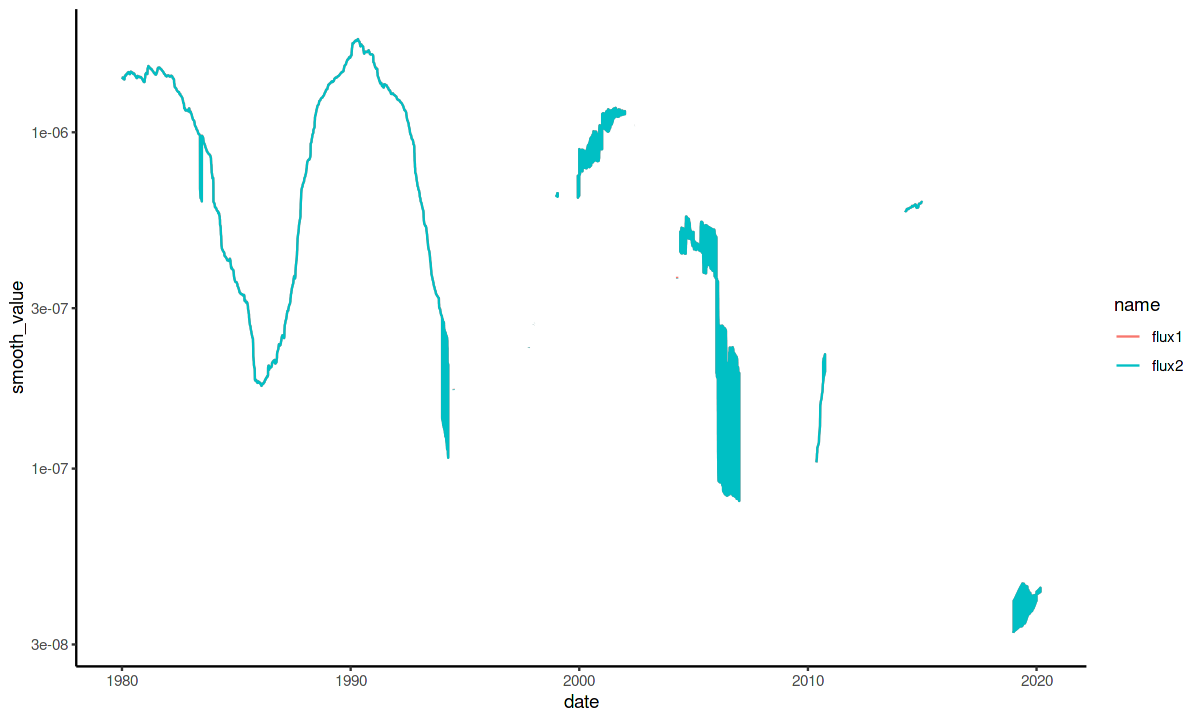

In [85]:
goes_daily %>% pivot_longer(flux1:flux2) %>% 
    mutate(value = ifelse(value > 1e-4, NA, value)) %>%  
    mutate(smooth_value = slide_dbl(value, mean, .before = 1000, .after = 1000)) %>% 
    ggplot + geom_line(aes(x = date, y = smooth_value, color = name)) +
    scale_y_log10()

In [99]:
goes_daily

,t,sat,flux1_mean,flux2_mean,flux1_logmean,flux2_logmean,flux1_med,flux2_med,flux1_min,flux2_max,flux1_std,flux2_std
,<date>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1980-01-04,go02,1.726347e-06,2.379783e-08,-13.31564,-17.94168,1.479e-06,1.368e-08,1.395e-07,7.313e-07,5.899100e-07,2.936747e-08
1,1980-01-05,go02,1.691449e-06,2.569799e-08,-13.33342,-17.97886,1.551e-06,1.529e-08,4.329e-07,1.419e-06,6.336994e-07,6.407699e-08
2,1980-01-06,go02,3.479739e-06,2.761435e-07,-12.90495,-17.25269,2.092e-06,2.092e-08,1.299e-06,1.246e-04,7.066104e-06,2.040205e-06
3,1980-01-07,go02,3.347606e-06,1.735538e-07,-13.00204,-17.45621,2.056e-06,2.172e-08,8.000e-10,1.806e-04,2.738676e-05,2.725294e-06
4,1980-01-08,go02,4.204871e-06,3.946333e-07,-12.83090,-16.87275,2.309e-06,3.177e-08,7.667e-07,1.578e-04,9.983059e-06,3.123667e-06
5,1980-01-09,go02,2.762496e-06,1.647243e-07,-13.01116,-17.99093,1.984e-06,1.448e-08,1.515e-06,4.405e-05,4.871808e-06,1.285261e-06
6,1980-01-10,go02,5.609191e-06,5.243886e-07,-12.53119,-16.70821,2.669e-06,5.188e-08,7.448e-09,1.605e-05,8.628926e-06,1.815951e-06
7,1980-01-11,go02,3.473751e-06,1.036893e-07,-12.69135,-16.98271,3.030e-06,6.072e-08,2.202e-07,1.519e-05,1.254165e-05,2.400500e-07
8,1980-01-12,go02,4.852758e-06,2.243373e-07,-12.38457,-16.16959,3.860e-06,9.973e-08,1.845e-08,9.819e-06,7.534981e-06,6.143928e-07


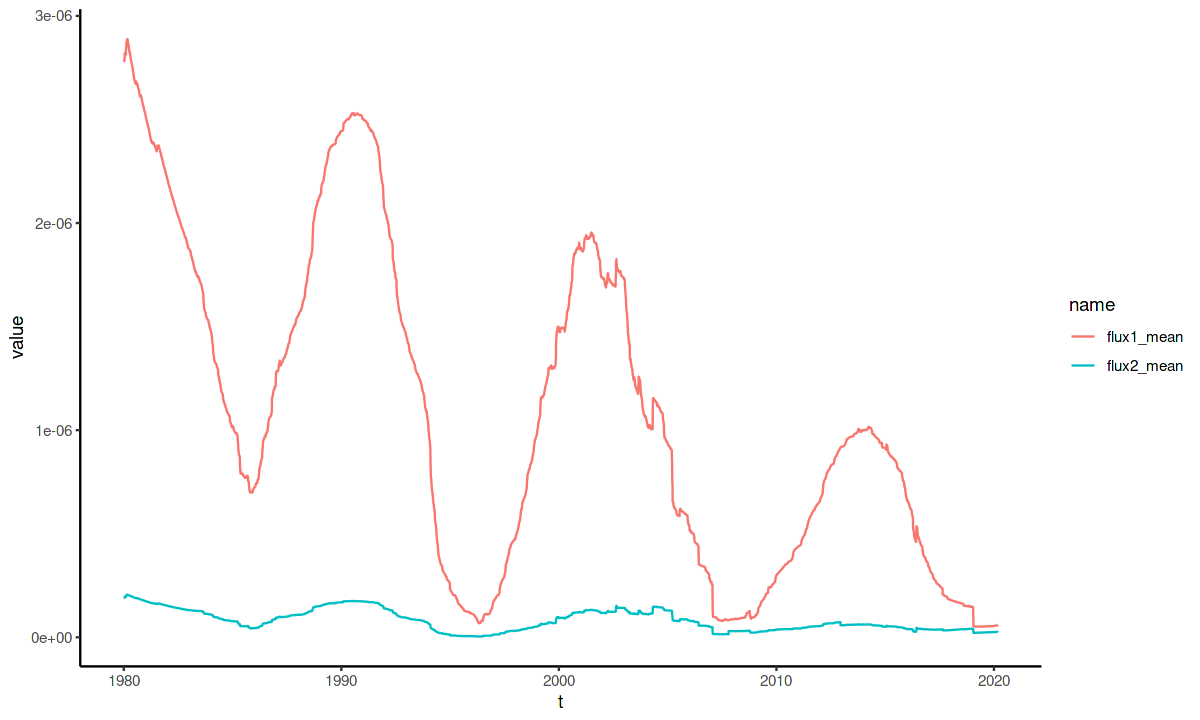

In [101]:
library(slider)

goes_daily %>% pivot_longer(flux1_mean:flux2_mean) %>% 
    group_by(name) %>% arrange(t) %>% 
    mutate(value = ifelse(value > 1e-4, NA, value)) %>% 
    mutate(value = slide_dbl(value, \(v) mean(v, na.rm = T), .before=1000, .after=1000)) %>% 
    ggplot + geom_line(aes(x = t, y = value, color = name))

## Time series analysis
In this lecture we will do more time series analysis. To make things easier, we'll need rely
on some nice libraries in R:

In [10]:
library(tsibble)
library(feasts)
library(fable)

Loading required package: fabletools



First we will convert the dataset to a special kind of tibble that understands time series operations:

In [71]:
library(tsibble)

#  load(url('https://github.com/terhorst/stats504/raw/refs/heads/main/lectures/week5/goes_daily_2.RData'))

load('goes_daily_2.RData')

goes_daily_2 %>% 
    filter(pmax(flux1_max, flux2_max) < 1e-3) %>% 
    as_tsibble(index=t, key=sat) %>% 
    ungroup ->
    goes_daily_ts

goes_daily_ts %>% print

# A tsibble: 21,025 x 14 [1D]
# Key:       sat [12]
   t          sat    flux1_mean flux2_mean flux1_logmean flux2_logmean flux1_med
   <date>     <fct>       <dbl>      <dbl>         <dbl>         <dbl>     <dbl>
 1 1980-01-04 go02  0.00000173     2.38e-8         -13.3         -17.9   1.48e-6
 2 1980-01-05 go02  0.00000169     2.57e-8         -13.3         -18.0   1.55e-6
 3 1980-01-06 go02  0.00000348     2.76e-7         -12.9         -17.3   2.09e-6
 4 1980-01-08 go02  0.00000420     3.95e-7         -12.8         -16.9   2.31e-6
 5 1980-01-09 go02  0.00000276     1.65e-7         -13.0         -18.0   1.98e-6
 6 1980-01-10 go02  0.00000561     5.24e-7         -12.5         -16.7   2.67e-6
 7 1980-01-12 go02  0.00000485     2.24e-7         -12.4         -16.2   3.86e-6
 8 1980-01-16 go02  0.00000159     3.89e-8         -13.4         -17.9   1.41e-6
 9 1980-01-17 go02  0.00000112     1.45e-8         -13.7         -18.4   1.11e-6
10 1980-01-18 go02  0.000000949    1.12e-8         -13.9 

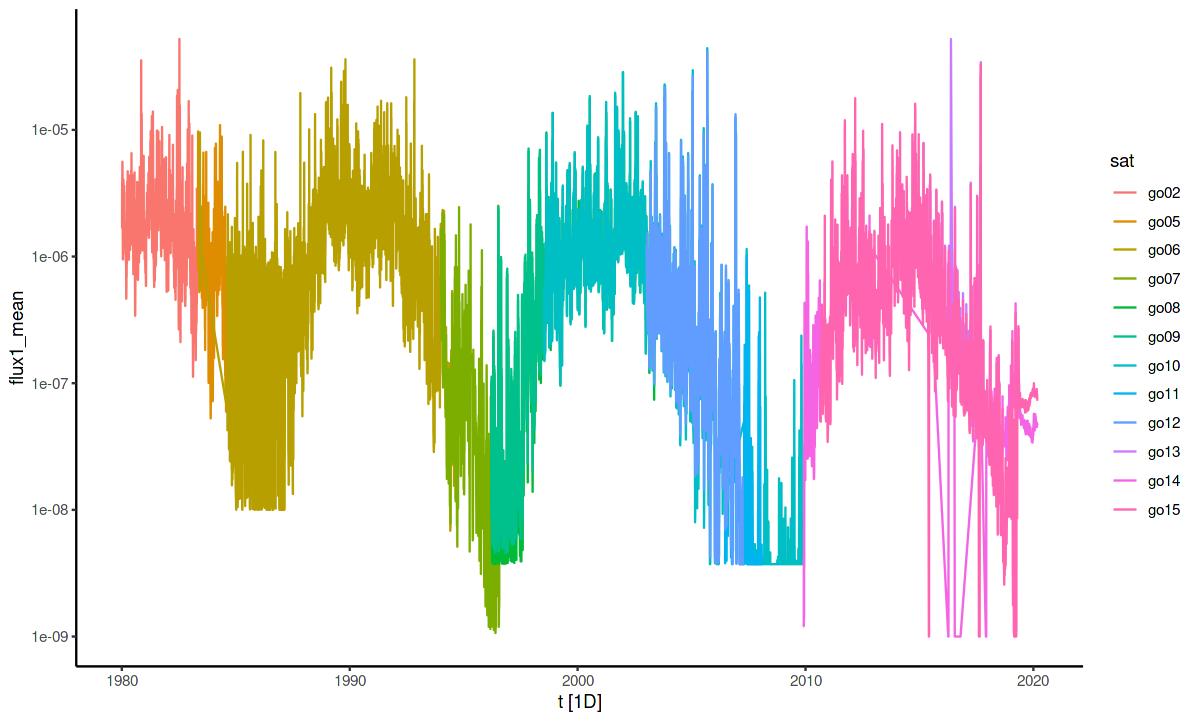

In [72]:
goes_daily_ts %>% autoplot(flux1_mean) + scale_y_log10()

## Quiz 🤷  
Sometime in 2012 there was an [X-class solar flare](https://svs.gsfc.nasa.gov/10109/) event. When did it happen?

A. March 7<br/>
B. December 25<br/>
C. October 23<br/>
D. July 6<br/>

In [21]:
# 2012 solar flare?

## Quiz 🤷  
When was the highest recorded solar output in the last 20 years?

A. September 6, 2017<br/>
B. January 10, 1864<br/>
C. July 27, 1983<br/>
D. September 26, 1982<br/>

In [36]:
# solar activity

## Quiz 🤷
According to the data, what's the probability that yesterday's daily maximum solar output is higher than today's daily maximum?

A. About 1/2<br/>
B. Significantly >1/2 <br/>
C. Significantly <1/2 <br/>

In [37]:
# Probability

## Quiz 🤷
On average, is the daily median `log10(flux1)` increasing or decreasing over the past 45 years? By how much?

A. Decreasing by about .0006 per year.<br/>
B. Increasing by about .001 per year.<br/>
C. No significant change.<br/>

In [58]:
# change per year

## Quiz 🤷
How does the *variance* in solar output compare for the current solar cycle ([S24](https://en.wikipedia.org/wiki/Solar_cycle_24_)) versus the last ([S23](https://en.wikipedia.org/wiki/Solar_cycle_23))?

A. Greater.<br/>
B. Less.<br/>
C. No significant change.<br/>

In [300]:
# variance in solar output

## Decomposing the solar cycle
Can we learn from data that the solar cycle is ~11 years long?

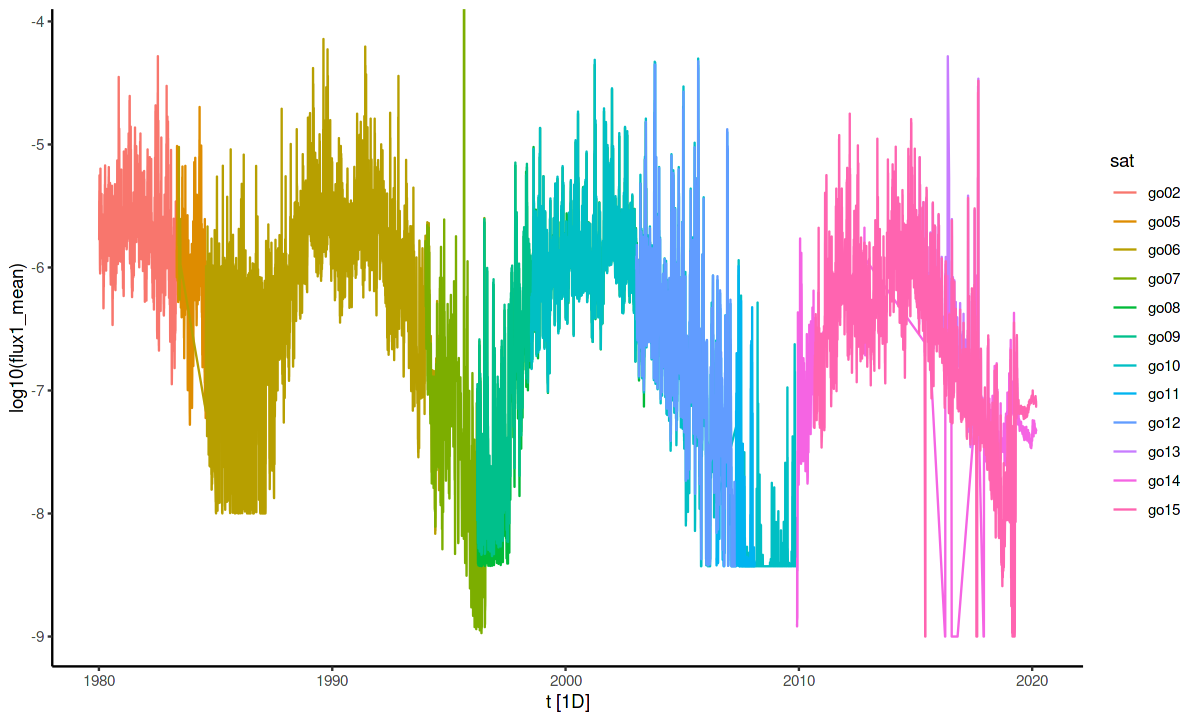

In [60]:
goes_daily_ts %>% autoplot(log10(flux1_mean))

In [376]:
goes_daily_ts1 %>% 
    fill_gaps %>% 
    fill(flux1, flux2) %>% 
    filter(year(date) == 2005, month(date) == 11, day(date) == 16)

date,flux1,flux2
<date>,<dbl>,<dbl>
2005-11-16,6.764132e-07,4.619255e-08


In [68]:
smooth_goes <- function(k) {
    goes_daily_ts %>%
        fill_gaps %>% 
        fill(flux1_med) %>% 
        mutate(slf1 = slide_dbl(log10(flux1_med), \(x) mean(x, na.rm=T), .before=k, .after=k))
}

[1] 4015

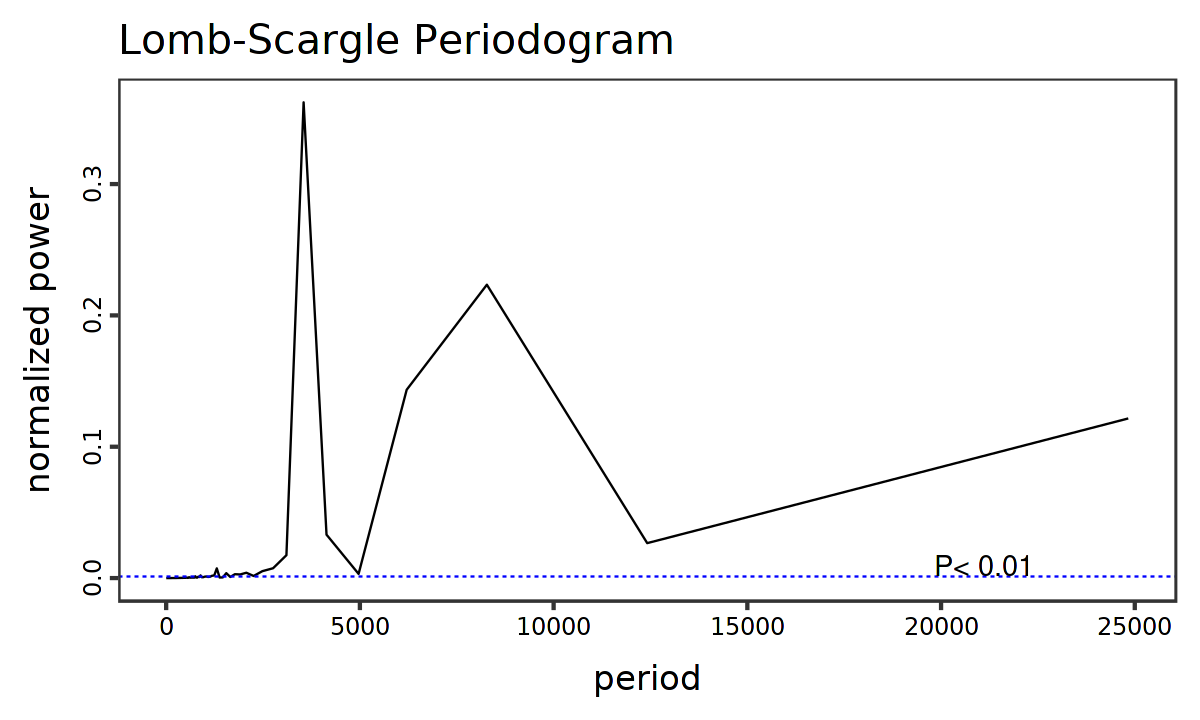

In [73]:
library(slider)
library(lomb)
smooth_goes(1000) %>% pluck('slf1') %>% lsp(type = "period")

11 * 365

## Other types of decompositions

There are some well-known decompositions that analysts often apply to time-series data. We'll look at two:
- Classical decomposition
- STL

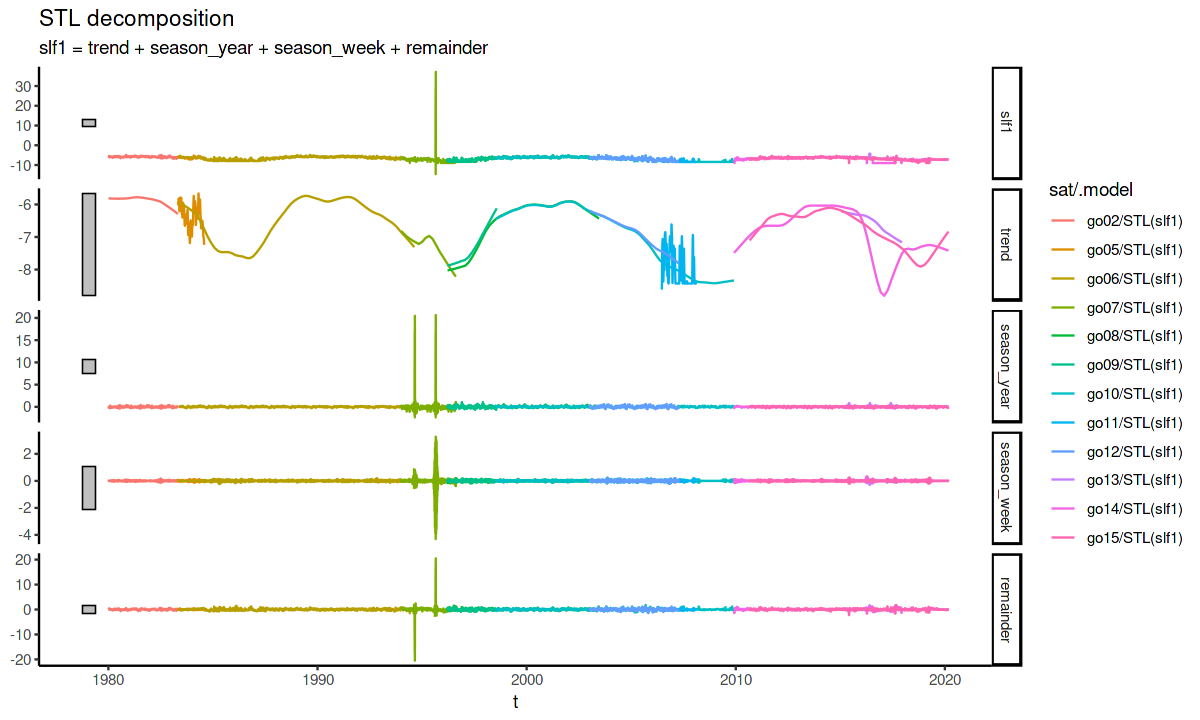

In [70]:
smooth_goes(0) %>% model(STL(slf1))  %>% 
    components %>% autoplot

## STL decomposition
STL decomposes the time series into *s*easonal and *t*rend (using a *L*OESS smoother).

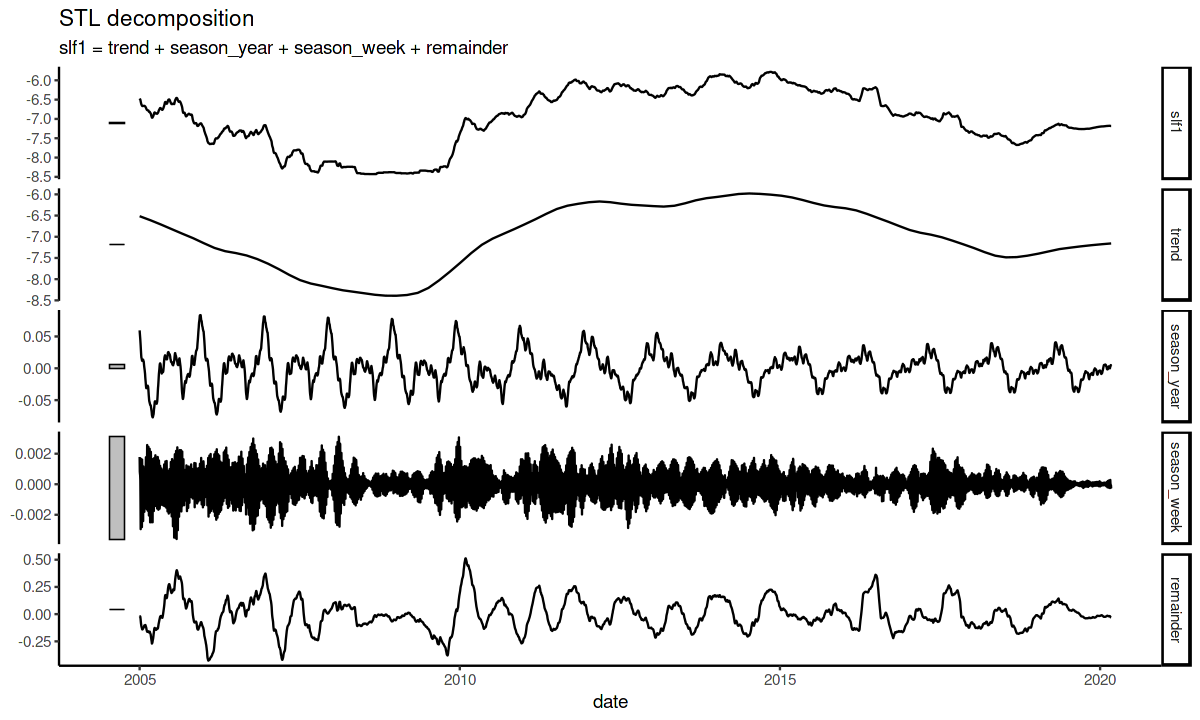

In [281]:
smooth_goes(50) %>% model(STL(slf1)) %>% 
    components %>% autoplot

## Autocorrelations
An autocorrelation plot shows the amount of correlation between a time series and its lags. It can be used to diagnose whether there are seasonal or trend components, since:
- When data have a trend, the correlations for small lags tend to be large and positive (why?) => AFC will have positive values that slowly decrease with lag length.
- When data are seasonal, the autocorrelations will be larger at multiples of the seasonal period.

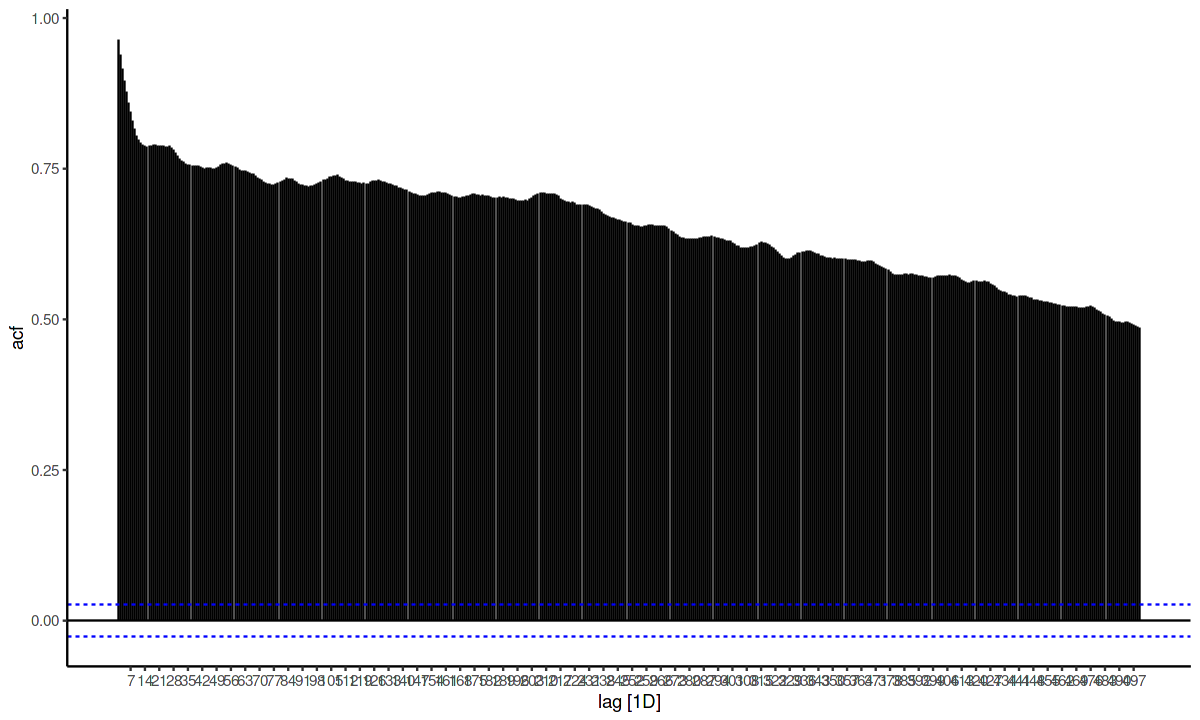

In [405]:
smooth_goes(0) %>% ACF(slf1, lag_max=500) %>% autoplot

## The Hurst coefficient
The [Hurst exponent](https://en.wikipedia.org/wiki/Hurst_exponent) $H$ measures how much "memory" a time series has:

- $H\in[0.5,1]$ indicates a time series with long-term positive autocorrelation: a high value tends to be followed by another high value and that future excursions to more high values do occur. 
- $H\in[0,0.5]$ indicates a time series with long-term switching between high and low values in adjacent pairs, meaning that a single high value will probably be followed by a low value and that the value after that will tend to be high
- A value of $H\approx 0.5$ indicates short-memory, with (absolute) autocorrelations decaying exponentially quickly to zero.

In [410]:
smooth_goes(1000) %>% features(flux1, coef_hurst)

coef_hurst
<dbl>
0.9384903


In [306]:
 %>% features(slf1, coef_hurst)

coef_hurst
<dbl>
0.99986


## Predicting solar flares

Can we predict the occurrence of solar flares using these data? Recall how we classify different solar flares:

https://en.wikipedia.org/wiki/Solar_flare#Classification

In [93]:
goes_daily_ts %>% mutate(flare = cut(log10(flux2_max), breaks=c(-Inf, -7:-4, Inf), 
                                     labels=c("A", "B", "C", "M", "X"))) %>% xtabs(~ flare, .)

flare
    A     B     C     M     X 
10173  5249  3317  2101   185 

In [86]:
table(goes_daily_ts$flare)

Warning message:
“Unknown or uninitialised column: `flare`.”


< table of extent 0 >

[1] -7 -6 -5 -4